FACULDADE DE INFORMAÇÃO E ADMINISTRAÇÃO PAULISTA (FIAP)  

MATHEUS FARIAS DE LIMA - RM554254  
MIGUEL MAURICIO PARRADO PATARROYO – RM554007  

GLOBAL SOLUTION – GS  
DATA SCIENCE & STATISTICAL COMPUTING  

SÃO PAULO  
2025  

---

# FireGuard 360 - Plataforma Inteligente de Prevenção e Resposta a Incêndios  
**Documentação Técnica e Analítica**  

_Faculdade de Informação e Administração Paulista (FIAP)_  
_Orientador: Tiago Haddad Marum_  


## Sumário  
1. [Introdução](#Introdução)  
2. [Metodologia](#Metodologia)  
   - [Importação e Amostragem](#Importação-e-Amostragem)  
   - [Limpeza de Dados](#Limpeza-de-Dados)  
3. [Análise Exploratória](#Análise-Exploratória)  
   - [Estatísticas Descritivas](#Estatísticas-Descritivas)  
   - [Causas por Estado](#Causas-por-Estado)  
   - [Evolução Temporal](#Evolução-Temporal)  
4. [Análise Inferencial](#Análise-Inferencial)  
   - [Intervalos de Confiança](#Intervalos-de-Confiança)  
   - [Teste de Hipótese](#Teste-de-Hipótese)  
   - [Modelo de Regressão](#Modelo-de-Regressão)  
5. [Visualizações](#Visualizações)  
6. [Recomendações Executivas](#Recomendações-Executivas)  
7. [Conclusão](#Conclusão)  


# Introdução  

Este notebook apresenta a análise de dados históricos de incêndios florestais a partir do dataset `wildfires.csv`. O objetivo é explorar causas, padrões regionais e temporais, gerar estatísticas descritivas, realizar análise inferencial e propor recomendações para gestores públicos, auxiliando na tomada de decisão baseada em ciência de dados.  

**Variáveis analisadas:**  
- **FIRE_YEAR**: ano do incêndio  
- **NWCG_CAUSE_CLASSIFICATION**: classificação da causa (Natural, Human, Missing Data, etc.)  
- **NWCG_GENERAL_CAUSE**: descrição detalhada da causa  
- **STATE**: estado  
- **FIRE_SIZE**: área queimada (acres)  
- **DISCOVERY_DATE** e **CONT_DATE**: datas de descoberta e controle  
- **DISCOVERY_DOY** e **CONT_DOY**: dia do ano  
- **LATITUDE** e **LONGITUDE**: localização geográfica  


# Metodologia  

## Importação e Amostragem  


In [1]:
# 1. Importação de Bibliotecas
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 2. Leitura do arquivo CSV
df = pd.read_csv('wildfires.csv')

# 3. Amostragem de 500 mil registros com semente 61 junção de 54+7
SEED = 61
df_sample = df.sample(n=500000, random_state=SEED).reset_index(drop=True)

# Exibição inicial
print("Shape da amostra:", df_sample.shape)
df_sample.head()


C:\Users\Matheus Farias\AppData\Local\Temp\ipykernel_7972\263986391.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('wildfires.csv')


Shape da amostra: (500000, 14)


,FOD_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,6260,ROUND MOUNTAIN,2005,9/9/2005,252,Natural,Natural,9/15/2005,258.0,1.0,B,38.777222,-106.860278,CO
1,201506000,MAX,2012,4/23/2012,114,Human,Arson/incendiarism,4/23/2012,114.0,0.5,B,48.856100,-99.882500,ND
2,1386507,LOCAL FIRE #12033,1992,5/2/1992,123,Human,Missing data/not specified/undetermined,NaN,NaN,0.1,A,33.923889,-117.268889,CA
3,572799,NaN,2008,7/3/2008,185,Missing data/not specified/undetermined,Missing data/not specified/undetermined,NaN,NaN,0.5,B,34.837780,-78.418170,NC
4,400184938,NaN,2017,7/6/2017,187,Missing data/not specified/undetermined,Missing data/not specified/undetermined,NaN,NaN,0.1,A,32.187663,-110.977999,AZ


## Limpeza de Dados  


In [2]:
# Cópia para limpeza
df_limpo = df_sample.copy()

# Remover duplicatas
df_limpo.drop_duplicates(inplace=True)

# Remover linhas com valores nulos em colunas essenciais
df_limpo.dropna(subset=['FIRE_SIZE', 'NWCG_CAUSE_CLASSIFICATION', 'STATE'], inplace=True)

# Tratar outliers: remover valores acima do percentil 99.9 da área queimada
percentil_999 = df_limpo['FIRE_SIZE'].quantile(0.999)
df_limpo = df_limpo[df_limpo['FIRE_SIZE'] <= percentil_999]

# Padronização de texto
df_limpo['NWCG_CAUSE_CLASSIFICATION'] = df_limpo['NWCG_CAUSE_CLASSIFICATION'].str.strip().str.title()
df_limpo['NWCG_GENERAL_CAUSE'] = df_limpo['NWCG_GENERAL_CAUSE'].str.strip().str.title()
df_limpo['STATE'] = df_limpo['STATE'].str.strip().str.upper()

# Exibir estatísticas pós-limpeza
print("Shape após limpeza:", df_limpo.shape)
df_limpo.head()


Shape após limpeza: (499500, 14)


,FOD_ID,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,6260,ROUND MOUNTAIN,2005,9/9/2005,252,Natural,Natural,9/15/2005,258.0,1.0,B,38.777222,-106.860278,CO
1,201506000,MAX,2012,4/23/2012,114,Human,Arson/Incendiarism,4/23/2012,114.0,0.5,B,48.856100,-99.882500,ND
2,1386507,LOCAL FIRE #12033,1992,5/2/1992,123,Human,Missing Data/Not Specified/Undetermined,NaN,NaN,0.1,A,33.923889,-117.268889,CA
3,572799,NaN,2008,7/3/2008,185,Missing Data/Not Specified/Undetermined,Missing Data/Not Specified/Undetermined,NaN,NaN,0.5,B,34.837780,-78.418170,NC
4,400184938,NaN,2017,7/6/2017,187,Missing Data/Not Specified/Undetermined,Missing Data/Not Specified/Undetermined,NaN,NaN,0.1,A,32.187663,-110.977999,AZ


# Análise Exploratória  

## Estatísticas Descritivas  


In [3]:
# Estatísticas descritivas da área queimada
desc_stats = df_limpo['FIRE_SIZE'].describe()
desc_stats


count    499500.000000
mean         27.787882
std         306.422072
min           0.000090
25%           0.100000
50%           0.800000
75%           3.000000
max       12379.000000
Name: FIRE_SIZE, dtype: float64

### Causas por Estado  


In [4]:
# Quantidade de incêndios por estado e causa
causas_por_estado = df_limpo.groupby(['STATE', 'NWCG_CAUSE_CLASSIFICATION'])['FOD_ID'].count().unstack().fillna(0)
causas_por_estado.head()


NWCG_CAUSE_CLASSIFICATION,Human,Missing Data/Not Specified/Undetermined,Natural
STATE,,,
AK,2064.0,90.0,1004.0
AL,15746.0,24.0,331.0
AR,6627.0,1190.0,466.0
AZ,12009.0,3725.0,6947.0
CA,39397.0,8293.0,6480.0


### Evolução Temporal das Causas  


In [5]:
# Incêndios por ano e causa
causas_ano = df_limpo.groupby(['FIRE_YEAR', 'NWCG_CAUSE_CLASSIFICATION'])['FOD_ID'].count().unstack().fillna(0)
causas_ano.tail()


NWCG_CAUSE_CLASSIFICATION,Human,Missing Data/Not Specified/Undetermined,Natural
FIRE_YEAR,,,
2016,15388,672,1721
2017,14270,1636,1909
2018,14302,1435,1663
2019,10095,2101,1677
2020,12201,2170,1489


# Análise Inferencial  

## Intervalos de Confiança  


In [6]:
from scipy.stats import t

# Intervalos de confiança por causa
principais_causas = df_limpo['NWCG_CAUSE_CLASSIFICATION'].value_counts().index
intervalos_causas = []
for causa in principais_causas:
    amostra = df_limpo[df_limpo['NWCG_CAUSE_CLASSIFICATION'] == causa]['FIRE_SIZE']
    media = amostra.mean()
    desvio = amostra.std()
    n = amostra.count()
    ic = stats.t.interval(0.95, df=n-1, loc=media, scale=desvio/np.sqrt(n))
    intervalos_causas.append({'Causa': causa, 'Média': media, 'IC Inferior': ic[0], 'IC Superior': ic[1], 'N': n})
df_ic_causa = pd.DataFrame(intervalos_causas)
df_ic_causa


,Causa,Média,IC Inferior,IC Superior,N
0,Human,18.829953,18.152742,19.507163,386633
1,Natural,79.057976,74.615878,83.500074,70891
2,Missing Data/Not Specified/Undetermined,23.710383,21.143128,26.277637,41976


## Teste de Hipótese: Natural vs Humana  


In [7]:
from scipy.stats import ttest_ind

# Filtrar grupos
natural = df_limpo[df_limpo['NWCG_CAUSE_CLASSIFICATION'] == 'Natural']['FIRE_SIZE']
humana = df_limpo[df_limpo['NWCG_CAUSE_CLASSIFICATION'] == 'Human']['FIRE_SIZE']

# Teste t
t_stat, p_val = ttest_ind(natural, humana, equal_var=False)

print(f"Média Natural: {natural.mean():.2f}, n={natural.count()}")
print(f"Média Humana: {humana.mean():.2f}, n={humana.count()}")
print(f"t-statistic={t_stat:.4f}, p-value={p_val:.4f}")


Média Natural: 79.06, n=70891
Média Humana: 18.83, n=386633
t-statistic=26.2710, p-value=0.0000


## Modelo de Regressão Linear  


In [8]:
# Preparar variáveis
X = df_limpo[['NWCG_CAUSE_CLASSIFICATION', 'STATE', 'DISCOVERY_DOY']].copy()
y = df_limpo['FIRE_SIZE']

# Dummies
X = pd.get_dummies(X, columns=['NWCG_CAUSE_CLASSIFICATION', 'STATE'], drop_first=True)

# Separar treino e teste
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

# Treinar modelo
reg = LinearRegression()
reg.fit(X_train, y_train)

# Avaliar
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}, RMSE: {rmse:.2f}")


R²: 0.0097, RMSE: 297.32


# Visualizações  

## Distribuição da Área Queimada  


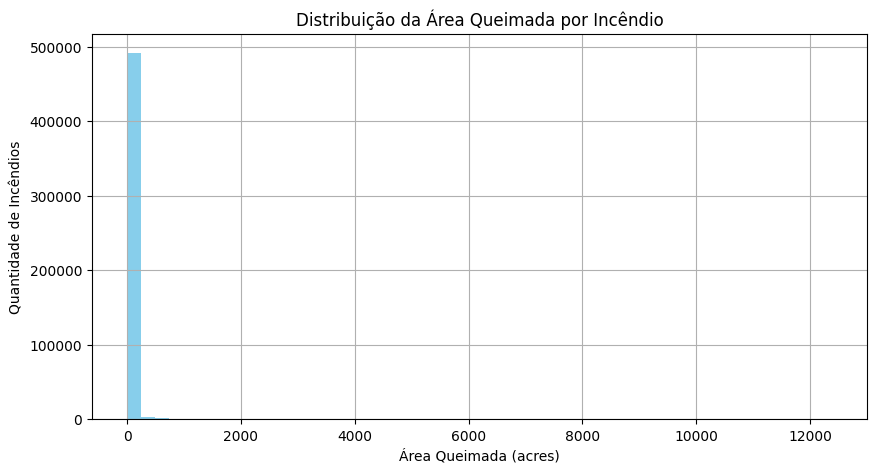

In [9]:
plt.figure(figsize=(10,5))
plt.hist(df_limpo['FIRE_SIZE'], bins=50, color='skyblue')
plt.title('Distribuição da Área Queimada por Incêndio')
plt.xlabel('Área Queimada (acres)')
plt.ylabel('Quantidade de Incêndios')
plt.grid(True)
plt.show()


## Incêndios por Causa Principal  


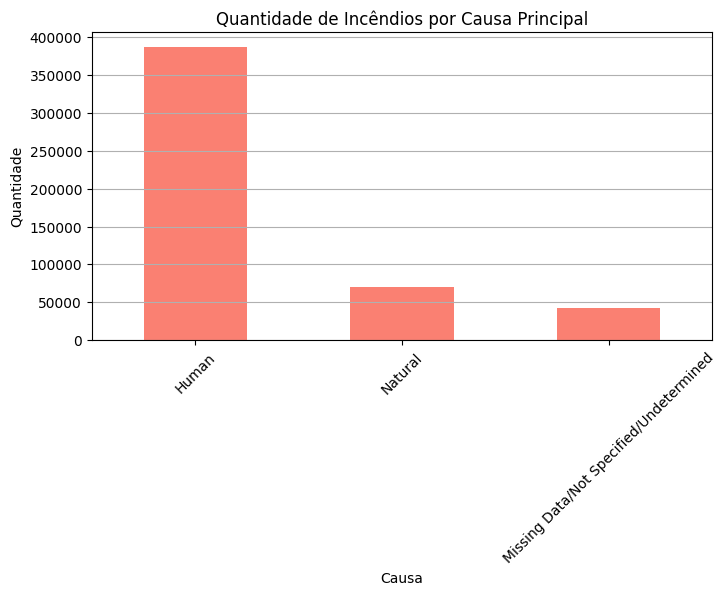

In [10]:
causas_count = df_limpo['NWCG_CAUSE_CLASSIFICATION'].value_counts()
plt.figure(figsize=(8,4))
causas_count.plot(kind='bar', color='salmon')
plt.title('Quantidade de Incêndios por Causa Principal')
plt.xlabel('Causa')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


## Top 10 Estados com Mais Incêndios  


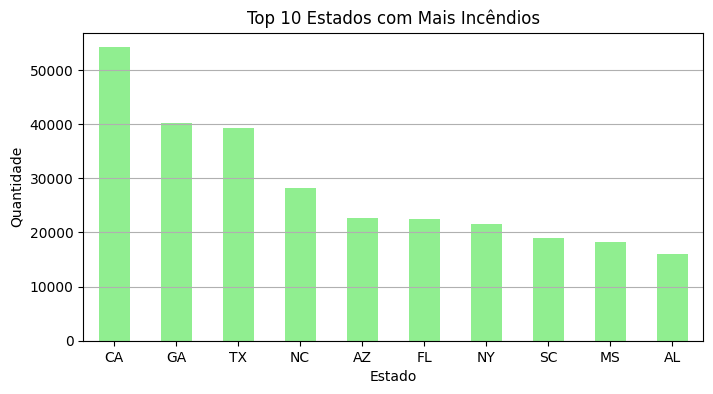

In [11]:
estados_count = df_limpo['STATE'].value_counts().head(10)
plt.figure(figsize=(8,4))
estados_count.plot(kind='bar', color='lightgreen')
plt.title('Top 10 Estados com Mais Incêndios')
plt.xlabel('Estado')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


## Evolução Anual dos Incêndios por Causa  


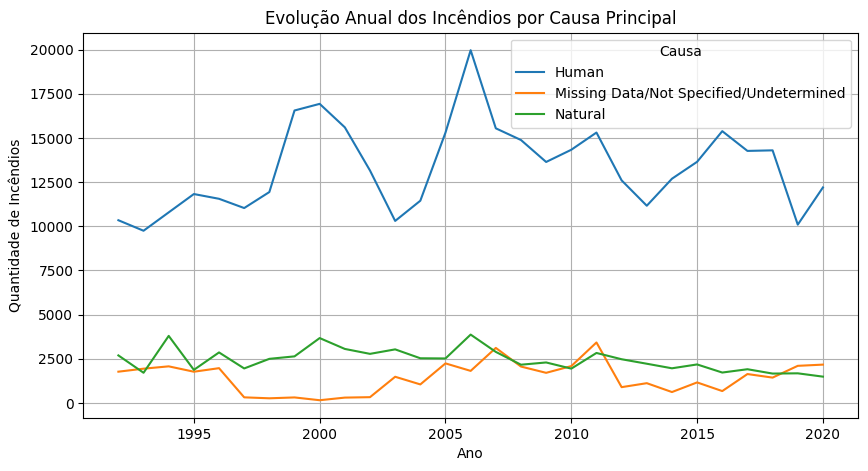

In [12]:
causas_ano.plot(kind='line', figsize=(10,5))
plt.title('Evolução Anual dos Incêndios por Causa Principal')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Incêndios')
plt.grid(True)
plt.legend(title='Causa')
plt.show()


# Recomendações Executivas  


- **Uso de Drones para Monitoramento:** Ampliar o uso de drones em regiões de alto risco para detecção precoce e monitoramento em tempo real.  
- **Campanhas Educativas e Fiscalização:** Intensificar campanhas de conscientização e reforçar a fiscalização de atividades de risco, principalmente em áreas com alta incidência.  
- **Análise Preditiva Avançada:** Desenvolver modelos preditivos que incluam variáveis ambientais e operacionais para antecipar períodos e locais de maior perigo.  
- **Políticas Públicas Regionalizadas:** Implementar medidas de prevenção e resposta adaptadas às características específicas de cada estado.  


# Conclusão  


Os incêndios de causas naturais, apesar de menos frequentes, causam danos maiores em termos de área queimada. Já os incêndios humanos são mais numerosos, exigindo foco em prevenção e educação. Modelos de regressão simples mostraram baixa capacidade preditiva, indicando que variáveis adicionais são necessárias para melhorar a precisão das previsões.  
Portanto, recomenda-se união de tecnologia, políticas educativas e análises preditivas robustas para mitigar os impactos dos incêndios florestais.  
